# Introduction

### Problem

In the project this week, we will build a machine learning text classifier to predict news categories from the news article text.

1. We will iterate on classification models with increasing level of complexity and improved performance: N-gram models, pre-trained Transformer models, and third-party hosted Large Language Models (LLMs).

2. We will look at the impact of labeled dataset size and composition on model performance. The labeled dataset will be used for training in case of N-gram models and pre-trained Transformers, and for selecting examples for in-context few-shot learning for LLMs.

3. [advanced] As an extension, we will explore how to augment data efficiently to your existing training data (efficiency measured as improvement in performance normalized by volume of data augmented).

Throughout the project there are suggested model architectures that we expect to work reasonably well for this problem. But if you wish to extend/modify any part of this pipeline, or explore new model architectures you should definitely feel free to do so.


In [ ]:
!nvidia-smi

Mon Jun 12 04:11:43 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    44W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Step1: Prereqs & Installation

Download & Import all the necessary libraries we need throughout the project.

In [ ]:
# Install all the required dependencies for the project

!pip install numpy
!pip install scikit-learn
!pip install sentence-transformers
!pip install matplotlib
!pip install langchain
!pip install openai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 10.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 114.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 81.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 117.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 88.2 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125926 sha256=0b3f2a1b0eb9aa6efcfe42cbb9f03a45762ebb83ec5270ca4a7136b128de5e38
 

In [ ]:
# Package imports that will be needed for this project

import numpy as np
import json
from collections import Counter
from sklearn.metrics import accuracy_score, f1_score
from sentence_transformers import SentenceTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from pprint import pprint
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

# [TO BE IMPLEMENTED]
# Add any other imports needed below depending on the model architectures you are using. For e.g.
# from sklearn.linear_model import LogisticRegression

In [ ]:
# Global Constants
LABEL_SET = [
    'Business',
    'Sci/Tech',
    'Software and Developement',
    'Entertainment',
    'Sports',
    'Health',
    'Toons',
    'Music Feeds'
]

SENTENCE_TRANSFORMER_MODEL = 'all-mpnet-base-v2'

TRAIN_SIZE_EVALS = [500, 1000, 10000, 25000]
EPS = 0.001
SEED = 0

np.random.seed(SEED)

## Step 2: Download & Load Datasets

[AG News](http://groups.di.unipi.it/~gulli/AG_corpus_of_news_articles.html) is a collection of more than 1 million news articles gathered from more than 2000 news sources by an academic news search engine. The news topic classification dataset & benchmark was first used in [Character-level Convolutional Networks for Text Classification (NIPS 2015)](https://arxiv.org/abs/1509.01626). The dataset has the text description (summary) of the news article along with some metadata. **For this project, we will use a slightly modified (cleaned up) version of this dataset**

Schema:
* Source - News publication source
* URL - URL of the news article
* Title - Title of the news article
* Description - Summary description of the news article
* Category (Label) - News category

Sample row in this dataset:
```
{
    'description': 'A capsule carrying solar material from the Genesis space '
                'probe has made a crash landing at a US Air Force training '
                'facility in the US state of Utah.',
    'id': 86273,
    'label': 'Entertainment',
    'source': 'Voice of America',
    'title': 'Capsule from Genesis Space Probe Crashes in Utah Desert',
    'url': 'http://www.sciencedaily.com/releases/2004/09/040908090621.htm'
 }
```




In [ ]:
from urllib.request import urlopen
from io import BytesIO
from zipfile import ZipFile

DIRECTORY_NAME = "data"
DOWNLOAD_URL = 'https://corise-mlops.s3.us-west-2.amazonaws.com/project1/agnews.zip'

def download_dataset():
    """
    Download the dataset. The zip contains three files: train.json, test.json and unlabeled.json
    """
    http_response = urlopen(DOWNLOAD_URL)
    zipfile = ZipFile(BytesIO(http_response.read()))
    zipfile.extractall(path=DIRECTORY_NAME)

# Expensive operation so we should just do this once
download_dataset()

In [ ]:
Datasets = {}

for ds in ['train', 'test_mini', 'augment']:
    with open('data/{}.json'.format(ds), 'r') as f:
        if ds == 'test_mini':
          Datasets['test'] = json.load(f)
        else:
          Datasets[ds] = json.load(f)
    print("Loaded Dataset {0}".format(ds))

print("\nExample train row:\n")
pprint(Datasets['train'][0])

print("\nExample test row:\n")
pprint(Datasets['test'][0])

Loaded Dataset train
Loaded Dataset test_mini
Loaded Dataset augment

Example train row:

{'description': 'A capsule carrying solar material from the Genesis space '
                'probe has made a crash landing at a US Air Force training '
                'facility in the US state of Utah.',
 'id': 86273,
 'label': 'Entertainment',
 'source': 'Voice of America',
 'title': 'Capsule from Genesis Space Probe Crashes in Utah Desert',
 'url': 'http://www.sciencedaily.com/releases/2004/09/040908090621.htm'}

Example test row:

{'description': "AP - Denny Neagle's contract was terminated by the Colorado "
                'Rockies on Monday, three days after the oft-injured pitcher '
                'was cited for solicitation.',
 'id': 116767,
 'label': 'Sports',
 'source': 'Yahoo Sports',
 'title': "Rockies Terminate Neagle's Contract (AP)",
 'url': 'http://us.rd.yahoo.com/dailynews/rss/sports/*http://story.news.yahoo.com/news?tmpl=story2 '
        'u=/ap/20041207/ap_on_sp_ba_ne/bbn_rocki

In [ ]:
X_train, Y_train = [], []
X_test, Y_true = [], []
X_augment, Y_augment = [], []

for row in Datasets['train']:
    X_train.append(row['description'])
    Y_train.append(row['label'])

for row in Datasets['test']:
    X_test.append(row['description'])
    Y_true.append(row['label'])

for row in Datasets['augment']:
    X_augment.append(row['description'])
    Y_augment.append(row['label'])

## Step 3: [Modeling part 1] N-gram model


### With `StandardScaler` Preprocessing Step

In [ ]:
models = {}

for n in TRAIN_SIZE_EVALS:
    print("Evaluating for training data size = {}".format(n))
    X_train_i = X_train[:n]
    Y_train_i = Y_train[:n]

    """
    [TO BE IMPLEMENTED]

    Goal: initialized below is a dummy sklearn Pipeline object with no steps.
    You have to replace it with a pipeline object which contains at least two steps:
    (1) mapping the input document to an N-gram feature extractor. You can use feature extractors
        provided by sklearn out of the box (e.g. CountVectorizer, TfidfTransformer)
    (2) a classifier that predicts the class label using the feature output of first step

    You can add other steps to preproces, post-process your data as you see fit.
    You can also try any sklearn model architecture you want, but a linear classifier
    will do just fine to start with

    e.g.
    pipeline = Pipeline([
        ('featurizer', <your N-gram featurizer class instance here>),
        ('classifier', <your sklearn classifier class instance here>)
    ])

    Reference: https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html
    """
    pipeline = Pipeline([
        ('vectorizer', CountVectorizer(ngram_range=(1, 2))),
        ("scaler", StandardScaler(with_mean=False)),
        ('classifier', LogisticRegression(max_iter=1000))
    ])

    # train
    pipeline.fit(X_train_i, Y_train_i)
    # predict
    Y_pred_i = pipeline.predict(X_test)
    # record results
    models[n] = {
        'pipeline': pipeline,
        'test_predictions': Y_pred_i,
        'accuracy': accuracy_score(Y_true, Y_pred_i),
        'f1': f1_score(Y_true, Y_pred_i, average='weighted'),
        'errors': sum([x != y for (x, y) in zip(Y_true, Y_pred_i)])
    }
    print("Accuracy on test set: {}".format(accuracy_score(Y_true, Y_pred_i)))

Evaluating for training data size = 500
Accuracy on test set: 0.259
Evaluating for training data size = 1000


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy on test set: 0.336
Evaluating for training data size = 10000


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy on test set: 0.649
Evaluating for training data size = 25000
Accuracy on test set: 0.708


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Without `StandardScaler` Preprocessing Step

In [ ]:
models = {}

for n in TRAIN_SIZE_EVALS:
    print("Evaluating for training data size = {}".format(n))
    X_train_i = X_train[:n]
    Y_train_i = Y_train[:n]

    """
    [TO BE IMPLEMENTED]

    Goal: initialized below is a dummy sklearn Pipeline object with no steps.
    You have to replace it with a pipeline object which contains at least two steps:
    (1) mapping the input document to an N-gram feature extractor. You can use feature extractors
        provided by sklearn out of the box (e.g. CountVectorizer, TfidfTransformer)
    (2) a classifier that predicts the class label using the feature output of first step

    You can add other steps to preproces, post-process your data as you see fit.
    You can also try any sklearn model architecture you want, but a linear classifier
    will do just fine to start with

    e.g.
    pipeline = Pipeline([
        ('featurizer', <your N-gram featurizer class instance here>),
        ('classifier', <your sklearn classifier class instance here>)
    ])

    Reference: https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html
    """
    pipeline = Pipeline([
        ('vectorizer', CountVectorizer(ngram_range=(1, 2))),
        # ("scaler", StandardScaler(with_mean=False)),
        ('classifier', LogisticRegression(max_iter=1000))
    ])

    # train
    pipeline.fit(X_train_i, Y_train_i)
    # predict
    Y_pred_i = pipeline.predict(X_test)
    # record results
    models[n] = {
        'pipeline': pipeline,
        'test_predictions': Y_pred_i,
        'accuracy': accuracy_score(Y_true, Y_pred_i),
        'f1': f1_score(Y_true, Y_pred_i, average='weighted'),
        'errors': sum([x != y for (x, y) in zip(Y_true, Y_pred_i)])
    }
    print("Accuracy on test set: {}".format(accuracy_score(Y_true, Y_pred_i)))

Evaluating for training data size = 500
Accuracy on test set: 0.551
Evaluating for training data size = 1000
Accuracy on test set: 0.597
Evaluating for training data size = 10000
Accuracy on test set: 0.724
Evaluating for training data size = 25000
Accuracy on test set: 0.749


## Step 4: [Modeling part 2] Pretrained Transformer model

In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Initialize the pretrained transformer model
sentence_transformer_model = SentenceTransformer(
    'sentence-transformers/{model}'.format(model=SENTENCE_TRANSFORMER_MODEL))

sentence_transformer_model.to(device)

# Sanity check
example_encoding = sentence_transformer_model.encode(
    "This is an example sentence",
    normalize_embeddings=True
)

print(example_encoding)


[ 2.25025900e-02 -7.82917067e-02 -2.30307188e-02 -5.10007096e-03
 -8.03404599e-02  3.91321704e-02  1.13428961e-02  3.46486131e-03
 -2.94575058e-02 -1.88930091e-02  9.47433785e-02  2.92747822e-02
  3.94859500e-02 -4.63165902e-02  2.54246034e-02 -3.21999118e-02
  6.21928275e-02  1.55591685e-02 -4.67795245e-02  5.03901616e-02
  1.46113848e-02  2.31413655e-02  1.22066820e-02  2.50696577e-02
  2.93658045e-03 -4.19822000e-02 -4.01037559e-03 -2.27843784e-02
 -7.68590532e-03 -3.31090689e-02  3.22118327e-02 -2.09992509e-02
  1.16730863e-02 -9.85073894e-02  1.77932634e-06 -2.29932126e-02
 -1.31140864e-02 -2.80222520e-02 -6.99970722e-02  2.59314012e-02
 -2.89501883e-02  8.76336321e-02 -1.20919021e-02  3.98605317e-02
 -3.31381932e-02  3.59108262e-02  3.46098915e-02  6.49784058e-02
 -3.00817229e-02  6.98187947e-02 -3.99511913e-03 -1.01598608e-03
 -3.50185595e-02 -4.36567143e-02  5.08025736e-02  4.68758158e-02
  5.39663211e-02 -4.03008275e-02  3.20143020e-03  1.36617851e-02
  3.82188372e-02 -3.23847

In [ ]:
class TransformerFeaturizer(BaseEstimator, TransformerMixin):
    def __init__(self, dim, sentence_transformer_model):
        self.dim = dim
        self.sentence_transformer_model = sentence_transformer_model
        # you can add any other params to be passed to the constructor here

    #estimator. Since we don't have to learn anything in the featurizer, this is a no-op
    def fit(self, X, y=None):
        return self

    #transformation: return the encoding of the document as returned by the transformer model
    def transform(self, X, y=None):
        X_t = []
        """
        [TO BE IMPLEMENTED]

        Goal: TransformerFeaturizer's transform() method converts the raw text document
        into a feature vector to be passed as input to the classifier.

        Given below is a dummy implementation that always maps it to a zero vector.
        You have to implement this function so it uses computes a document embedding
        of the input document using self.sentence_transformer_model.
        This will be our feature representation of the document
        """
        for doc in X:
            # TODO: replace this dummy implementation
            X_t.append(self.sentence_transformer_model.encode(doc, normalize_embeddings=True))
        return X_t

In [ ]:
models_v2 = {}
embedding_dim = 768
for n in TRAIN_SIZE_EVALS:
    print("Evaluating for training data size = {}".format(n))
    X_train_i = X_train[:n]
    Y_train_i = Y_train[:n]

    """
    [TO BE IMPLEMENTED]

    Goal: initialized below is a dummy sklearn Pipeline object with no steps.
    You have to replace it with a pipeline object which contains at least two steps:
    (1) mapping the input document to a feature vector (using TransformerFeaturizer)
    (2) a classifier that predicts the class label using the feature output of first step

    You can add other steps to preproces, post-process your data as you see fit.
    You can also try any sklearn model architecture you want, but a linear classifier
    will do just fine to start with

    e.g.
    pipeline = Pipeline([
        ('featurizer', <your TransformerFeaturizer class instance here>),
        ('classifier', <your sklearn classifier class instance here>)
    ])
    """
    pipeline = Pipeline([
        ('featurizer', TransformerFeaturizer(embedding_dim, sentence_transformer_model)),
        # ("scaler", StandardScaler(with_mean=False)),
        ('classifier', LogisticRegression(max_iter=1000))
    ])

    # train
    pipeline.fit(X_train_i, Y_train_i)
    # predict
    Y_pred_i = pipeline.predict(X_test)
    # record results
    models_v2[n] = {
        'pipeline': pipeline,
        'test_predictions': Y_pred_i,
        'accuracy': accuracy_score(Y_true, Y_pred_i),
        'f1': f1_score(Y_true, Y_pred_i, average='weighted'),
        'errors': sum([x != y for (x, y) in zip(Y_true, Y_pred_i)])
    }
    print("Accuracy on test set: {}".format(accuracy_score(Y_true, Y_pred_i)))


Evaluating for training data size = 500
Accuracy on test set: 0.717
Evaluating for training data size = 1000
Accuracy on test set: 0.74
Evaluating for training data size = 10000
Accuracy on test set: 0.771
Evaluating for training data size = 25000
Accuracy on test set: 0.789


## Step 5: [Modeling part 3] Large Language Models

In [ ]:
!pip install asyncio
!pip install nest_asyncio
!pip install tiktoken

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.8/101.8 kB 11.5 MB/s eta 0:00:00


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 66.1 MB/s eta 0:00:00


In [ ]:
import nest_asyncio

nest_asyncio.apply()

In [ ]:
from langchain.chat_models import ChatOpenAI
from langchain.schema import LLMResult, HumanMessage, Generation
import tiktoken

MODEL_NAME = "gpt-3.5-turbo"
encoding = tiktoken.encoding_for_model(MODEL_NAME)

def num_tokens_from_string(string, encoding_name = encoding) -> int:
    """Returns the number of tokens in a text string."""
    num_tokens = len(encoding.encode(string))
    return num_tokens

MAX_TOKENS = max(num_tokens_from_string(label) for label in LABEL_SET)

llm = ChatOpenAI(
    model_name=MODEL_NAME,
    max_tokens=MAX_TOKENS,
    temperature=0.0
)

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin
from langchain.callbacks import get_openai_callback
import asyncio
from asyncio import Semaphore

class LLMClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, llm_model, prompt_template, semaphore):
        self.llm_model = llm_model
        self.prompt_template = prompt_template
        self.semaphore = semaphore

    # This will be called during the training step
    def fit(self, X, y):
        return self

    # This will be called during inference.
    def predict(self, X):
        """
        [TO BE IMPLEMENTED]

        Goal: LLMClassifier's predict() method constructs the final prompt input
        for the LLM for each x in X, using the prompt template.

        You have to implement this function so it does the following:
        1. Construct the final prompt for the LLM
        2. Call `self.llm_model` to generate the completion (label) for the prompt
        3. Do any post-processing/response parsing to fetch the label from the LLM response
        """
        with get_openai_callback() as cb:
          prompts = [
              [[HumanMessage(content=self.prompt_template.format(article=document))]]
              for document in X
          ]
          result = asyncio.run(self.__generate_labels(prompts))
          print(f"Total Tokens: {cb.total_tokens}")
          print(f"Prompt Tokens: {cb.prompt_tokens}")
          print(f"Completion Tokens: {cb.completion_tokens}")
          print(f"Total Cost (USD): ${cb.total_cost}")
          print(result)
          return result

    async def __async_generate(self, prompt):
        async with self.semaphore:
          response = await self.llm_model.agenerate(prompt)
          label = response.generations[0][0].text
          print(label)
          return label

    async def __generate_labels(self, prompts):
        tasks = [self.__async_generate(prompt) for prompt in prompts]
        labels = await asyncio.gather(*tasks)
        return labels

In [ ]:
semaphore = Semaphore(2)

In [ ]:

zero_shot_prompt_template = """
You are an expert at judging the classification of articles.
Your job is to categorize the classification of a given article into one of eight categories: Business, Sci/Tech, Software and Developement, Entertainment, Sports, Health, Toons, Music Feeds.

Article: {article}
Classification:
"""

prompt = zero_shot_prompt_template.format(
    article="A capsule carrying solar material from the Genesis space probe has made a crash landing at a US Air Force training facility in the US state of Utah."
)

result = llm.generate([[HumanMessage(content=prompt)]])
print(result.generations[0][0])


text='Sci/Tech' generation_info=None message=AIMessage(content='Sci/Tech', additional_kwargs={}, example=False)


In [ ]:

few_shot_prompt_template = """
You are an expert at judging the classification of tweets.
Your job is to categorize the classification of a given article into one of eight categories: Business, Sci/Tech, Software and Developement, Entertainment, Sports, Health, Toons, Music Feeds.

Some example articles along with the correct classification are shown below.

Article: Apple Computer Apple announced Thursday that music fans have purchased and downloaded more than 200 million songs from the iTunes Music Store since its launch in April of 2003.
Classification: Entertainment

Article: A capsule carrying solar material from the Genesis space probe has made a crash landing at a US Air Force training facility in the US state of Utah.
Classification: Sci/Tech

Article: A suspended physician working at a clinic in Oakland Park, Fla., injected himself and three other people with botulinum toxin that he had prepared as if it were Botox, a licensed drug, rather than the far more potent, raw toxin it was, according to
Classification: Health

Now I want you to label the following example:
Article: {article}
Classification:
"""

prompt = few_shot_prompt_template.format(
    article="Beyonce will be performing in Toronto this weekend alongside Blue Ivy and Wizkid"
)

result = llm.generate([[HumanMessage(content=prompt)]])
print(result.generations[0][0])


text='Entertainment' generation_info=None message=AIMessage(content='Entertainment', additional_kwargs={}, example=False)


In [ ]:
# Zero-shot classification pipeline with LLMs

models_v3 = {}

"""
[TO BE IMPLEMENTED]

Goal: initialized below is a dummy sklearn Pipeline object with no steps.
You have to replace it with a pipeline object which uses the `LLMClassifier` you have implemented
above to perform zero-shot classification on the test set.

You can add other steps to preproces, post-process your data as you see fit.

"""
pipeline = Pipeline(
    [
      ('classifier', LLMClassifier(llm_model=llm, prompt_template=zero_shot_prompt_template, semaphore=semaphore))
    ]
)

# train
pipeline.fit(X_train_i, Y_train_i)
# predict
Y_pred_i = pipeline.predict(X_test)
# record results
models_v3["zero-shot"] = {
    'test_predictions': Y_pred_i,
    'accuracy': accuracy_score(Y_true, Y_pred_i),
    'f1': f1_score(Y_true, Y_pred_i, average='weighted'),
    'errors': sum([x != y for (x, y) in zip(Y_true, Y_pred_i)])
}
print("Accuracy on test set: {}".format(accuracy_score(Y_true, Y_pred_i)))

Sports
Sci/Tech
Sports
Business
Sports
Sports
Business
Sports
Politics/Current Events
Sports
Entertainment
Business
Sports
Business
Business
Business
Business
Health
Sci/Tech
Sci/Tech
Business
Sports
Military/Politics
None of the above categories. This article is related to politics or current events.
Sports
Politics/Current Events
None of the given categories fit this article. It may be classified as Politics/Current Events.
Entertainment
Sports
Sports
Business
Business
Crime/Justice (not one of the given categories)
Music Feeds
Business
Sports
Sports
Health
Health
Health
Software and Development
Music Feeds
Business
Sci/Tech
Business
Sci/Tech
Business
Business
Sports
Sci/Tech
Sports
Business
Sci/Tech
Entertainment
Sports
Sci/Tech
Sports
Business
Politics/International Affairs
Business
Health
Sports


Business
Business
Entertainment
Business
Health
Entertainment
Sci/Tech
Sci/Tech
Sci/Tech
Software and Development
Sports
Health
Sci/Tech
Health
Entertainment
Health
Sports
Politics/Current Events
Sports
Health
Sports
Sci/Tech
Sports
Sports
Sports
Entertainment
Health
Software and Development
Sports
Business
Sports
Politics/Government
None of the given categories fit this article. It is a news article about military operations in Iraq and does not fit into any of the provided categories.
Sports
Sports
Politics
Sports
Sci/Tech
Entertainment
Business
Sports
Sports
Sports
Business
Health
Animals/Pets
Entertainment
Sports
Entertainment


Sports
Sports
Sports
Business
Health
Sports
Weather/Natural Disasters
Sci/Tech
Sports
Sci/Tech
Politics/International Relations
Entertainment
Sports
Business
Politics
Business
Business
Business
Software and Development
Sports
Politics/Law
Software and Development
Business
Business
Sci/Tech
Health
Business
Sci/Tech
Sports
Sci/Tech
Sports
Politics
Business
Sports
Sports
Business
Sports
Sci/Tech
Sci/Tech
Sports
Entertainment
Business
Sports
Sports
Business
Music Feeds
Sci/Tech
Sports
Sports
Health
Entertainment
Politics/Current Events
Business
Business
Sports
Sports
Software and Development
Entertainment
Health
Business
Sports
Sports
Toons
Sports


Entertainment
Entertainment
Sports
Sci/Tech
Business
Sports
Entertainment
Health
Sports
Software and Development
Sports
Sports
Sci/Tech
Sports
Sci/Tech
Sports
Business
Sports
Health
Sports
Music Feeds
Entertainment
Entertainment
Sci/Tech
Health
Sci/Tech
Business
Health
Sports
Sci/Tech
Terrorism/International Affairs
Sports
Business
Sci/Tech
Health
Politics/Current Events
Sports
Health
Business
Entertainment
Health
Sports
Music Feeds
Sports
Sports
Sports
Sci/Tech
Entertainment
Sports


Sports
I'm sorry, but there is no article provided for me to classify. Please provide the article for me to categorize.
Sports


Sci/Tech


Health


Sports
Military/Conflict (not one of the given categories)


Music Feeds
Music Feeds


Entertainment
Business


Sci/Tech
Business
Sports


Entertainment
Sports
Entertainment


Sci/Tech
Sports


Sports


Business
Software and Development


Politics


Business
Sports


Music Feeds
Sports


Sports


Sports


Sports


Business
Sports


None of the given categories fit this article well. It may be classified as Crime or Terrorism.


Sports
Business
Politics/Current Affairs
Automotive


Health


Sci/Tech


Business


Sci/Tech
Business


None of the given categories fit this article. It is a news article about a current event in the Middle East.
Sci/Tech
Business


Health
Sci/Tech


Sports


Sports


Sports
Health


Sports


Entertainment
Politics


Health


Business


Entertainment
Sports


Business


Sports


Health


Health
Business
Sports


Sports


Entertainment


Weather/Natural Disaster
Sci/Tech


Entertainment


Sports


Business


Sports
Health


Sports
Business


Entertainment


None of the given categories fit this article. It is related to politics and conflict resolution in Northern Ireland.
Health
Sports
Business


None of the given categories fit this article perfectly, but the closest would be "Business" as it involves a coalmine and potential economic impact. However, it could also be classified as "Health" or "Safety" due to the danger posed to the trapped miners.
Music Feeds


Sports


Health
Business


Sports


Sci/Tech


Business


Business
Entertainment


Sports
Sports


Toons


Business


Sci/Tech


Business
Software and Development


Sports
Sports


Business


Sports
Health


Travel/Transportation
Health


Business


Business


Health


Health
Sci/Tech (incorrect classification) 

Correct classification: News/Current Events


Business


Sports


Business
Music Feeds


Sports
Business


Sports


Business


Sports


Sports
Sports
Sci/Tech


Sports


Sports


Sports


Health
Health


Sports


Sports


Entertainment
Sci/Tech


Business


Health


Sports


Business
Sports


Entertainment


Sports
Sports
Sports


Sports
Business


Politics


Sports


Sports
Sports


Politics/Current Events
Sports


Entertainment


Business


Sci/Tech


Sci/Tech
Sci/Tech
Entertainment


Sci/Tech


Politics


Health
Sci/Tech


Entertainment


Business


Sports
Business


Sports
Sci/Tech


Health


Politics


Business
Entertainment


Sports
Politics/Law


Music Feeds


Business


Sci/Tech
Business


Sports


Sports


Sports


Sports
Business


Politics/International Affairs
Entertainment


Sports


I'm sorry, but as an AI language model, I cannot categorize the classification of an article without having access to the article itself. Please provide me with the article so I can assist you better.
Health
Politics
Health


Sports


Sports


Sci/Tech
Sci/Tech


Entertainment


None of the given categories fit this article as it is about weapons and not related to any of the specified topics.
Sports


Politics/International Affairs
Sports


Sports


Business


Sci/Tech


Health


Business
Business
Sports


Software and Development
Sci/Tech


Sports


Sports


Business


Toons
Business


Entertainment


Entertainment


Entertainment
Business
Sports


Politics


Sports


Business


Health
Sci/Tech
None of the given categories fit this article. It may be classified as "World News" or "Current Events".


Sports
Politics/LGBTQ+ Rights


Sports


Sci/Tech


Politics
Business
Sports


Entertainment
Sports
Politics/International Affairs
Sports
Politics
Sci/Tech
This article would fall under the category of Crime or Law, which is not one of the given categories. However, if we had to choose from the given categories, it could potentially fall under Health (as it discusses the emotional trauma of the victim) or Entertainment (as it involves a high-profile trial).
Sports
Sports
Sports
Business
Sports
Sports
Sports
Business


Sports
Health
None of the given categories fit this article. It could potentially fall under the category of "World News" or "Crime/Justice."
Sports
Health
Travel/Transportation
News/Current Events (not one of the given categories)
Sci/Tech
Business
Sports
Sci/Tech
Sci/Tech
War/Conflict (not one of the given categories)
Sports
Business


Sports
Sports
Charity/Philanthropy (not one of the given categories)
Sports
Health
Sports
Health


Sports
Sports


News/International Affairs


Software and Development
Sports


Business


Business


Business


Sci/Tech
Business


Natural Disaster/Weather (not one of the given categories)
Entertainment
Business


Business
Politics/Current Events
Military/Conflict (not one of the given categories)
Politics
Business


Health
Sports
War/Conflict (not one of the given categories)
Sports
Entertainment
Health


Business
Business
Sci/Tech
Health
Health


Politics/Government
Sports
Sports
Sports


Sports
Business
Business
Sports
Software and Development


Sports
Sports
Sci/Tech
Politics/International Affairs
Sports
Business


Business
Business
Sports
Sports
Business
Sci/Tech


Business
Business


Sci/Tech
I'm sorry, but as an AI language model, I cannot categorize the classification of an article without having access to the article itself. Please provide me with the article so I can assist you better.
Entertainment
Sci/Tech
Sports
News (not one of the given categories)
Sports
Sports
Music Feeds
Sports
Sci/Tech
Business
Sports


Business
Sports
Sports
Health
Sports


Sports
None of the given categories fit this article well. It may be more appropriate for a general news or human interest section.
Sci/Tech
Sports
Politics
Travel/Tourism
Business
Sports


Politics
Business
Politics/Current Events
Sports
Business


Politics/International Affairs
Business
Sci/Tech
Software and Development
Sci/Tech
Sports


Sports
Entertainment
Business
Sports
Health
Sports


Sci/Tech
Business
Business
Business
Business


Business
Business


Entertainment
Business


Business


Sports


Sports


Sci/Tech


Business
Politics/Current Events


Health
Health


Business
Health


Sports


Sports
Sports
Sci/Tech
Business


Animals/Wildlife
Health


Health


Sci/Tech


Software and Development


Politics/Elections (not one of the given categories)
Sports


Business


Business


Business


Entertainment


Sports


Politics/World News
Software and Development
Sci/Tech
Sports


Sports
Sci/Tech


Health


Health
Entertainment


Sports


Sports


Entertainment
Sci/Tech


Entertainment
Sports


Sports
Sci/Tech


Health
Sports
None of the given categories fit this article. It may be classified as Politics or Current Affairs.


Politics/International Relations
Sports


Health


Business


Sports
Sports


Health
Business


Entertainment


Sports


Sci/Tech


Music Feeds
Health


Crime/Assault (not one of the given categories)
Business


Sci/Tech


Business
Business


Politics/International Affairs
Business
Sports


Sports
Software and Development


Business


Sports
Health


Sports


Sports


Entertainment
Sci/Tech
Business


Sports
Entertainment


Entertainment


Health


Sports


Entertainment
Sports


Sports


Sci/Tech


Business


Sports


Health
Business


Health


Health


Sci/Tech
Software and Development
Sci/Tech


Business


Sports


Sports
Business


Sports


Politics/Government


Animals/Wildlife (not one of the given categories)


Business
Politics/International Affairs


Sports


Sports
Sci/Tech


Health
Business


Business


Weather/Natural Disasters
Sports


Toons


Health


Sports


Sci/Tech
Sports
Politics/International Affairs


None of the given categories fit this article perfectly, but the closest would be "News" or "Current Events".
Business


Sports


Sci/Tech


Sports


Business
Health


Sci/Tech
Business
I'm sorry, but there is no article provided for me to classify. Please provide the article for me to categorize.


Sci/Tech


Entertainment


Music Feeds


Sports
Sports
Business


Business
Politics


Business


Sports


Health
Sports


Business


Health
Entertainment


Health


Sci/Tech


Entertainment


Sports
Sci/Tech


Business
Sports


Sports


Sports


Sports
Sports
Business


Software and Development


Business


Health


Sci/Tech
Software and Development
Sports


I'm sorry, but there is no article provided for me to classify. Please provide the article for me to categorize.
Sports


Military/Politics


Sports


Software and Development
Business


Business


Sports
Health
Sports


Sci/Tech
Business


Sports
Sci/Tech


Weather/Natural Disasters
Entertainment


Music Feeds


Business


Business
Politics


Politics/Current Events
Business


Business
Sports
Sports
Entertainment


Sports
Entertainment
Sports
Business
Business


Business
Sports
Travel/Transportation
Sports
News/Politics (not one of the given categories)
Business


Business


Health


Business


Sports
Business


Sports
Entertainment


Business


Sci/Tech


I'm sorry, but there is no article provided for me to classify. Please provide the article for me to categorize.
Sports
Sports


Sports


Software and Development
Sci/Tech
Business
Sports
Sci/Tech


Business
Health


Entertainment


Sci/Tech


Business


Business


Sports
Sports
Sports


Sports
Politics/International Affairs
Sports
Sports


Sci/Tech
Sports
Weather/Natural Disasters
Music Feeds
Entertainment
Sports


Entertainment
Business
Sci/Tech
Business
Health
Toons


Sports
Politics/Foreign Policy
Business
Software and Development


Health
None of the given categories fit this article. It may be classified as "Politics" or "Current Events".
Sports
Sports
Business
Sports


Health
Sci/Tech
This article does not fit into any of the given categories.
Sci/Tech
Business
Health
Business
Health


Business
Health
Sports
Business


Sports
Sports


Sports
Business


Sci/Tech


Business


Politics/Current Affairs
Business


I'm sorry, but there is no article provided for me to classify. Please provide the article for me to categorize.
Sports


I'm sorry, but there is no article provided for me to classify. Please provide the article for me to categorize.
Sports
Health


Business
Sports
Sports
Sports


Music Feeds
Business
Sports


Weather/Natural Disasters


Sports


Sports


Software and Development


Sci/Tech
Music Feeds


Sports
Business


None of the given categories fit this article. It may be classified as "Military/Politics" or "Current Events/News".
Health
Entertainment
Sports
Politics/Human Rights
Business


Sports
Politics


Music Feeds


Sports


Sci/Tech


Sports
Entertainment


Business
Entertainment


Software and Development


Health


Politics


I'm sorry, but there is no article provided for me to classify. Please provide the article for me to categorize.
Sports
Sci/Tech


Health


Entertainment


Sports
Health (as it involves a tragic incident resulting in loss of life and injury)


Sci/Tech
Business


Business


Sci/Tech


Sports
Sports


Business
Sports


Business
Sports


Business


Politics


Sports


Music Feeds


Business
Sci/Tech
Health


News (could fall under either Business or Health, depending on the focus of the article)


Entertainment
Business


Sports
Sports
Sports


Music Feeds


Business


Business
Entertainment


Business


Business


Sports


Sci/Tech


Business


Entertainment
Sci/Tech


Business
Entertainment


Business


Sports


Business


None of the given categories fit this article. It may be classified as "World News" or "Politics".
Business
Business


Sports


Sci/Tech (as it pertains to security and terrorism)
None of the given categories are appropriate for this article. It is a news article about a kidnapping and threat, and does not fit into any of the provided categories.
Business
Software and Development
Health
Sports
Business


Business
Business


Health
Sports


Software and Development
Sports


Health
Health


Sports
Health
Business
Sports
Sports
Entertainment
Health
Politics/International Relations
None of the given categories fit this article. It may be classified as "Research/Study" or "Psychology".
Business
Health
Sci/Tech
Sci/Tech
Health
Health
None of the given categories fit this article. It may be classified as "World News" or "Politics".
Entertainment
Sports
Sports
Business
Sports
Entertainment
Sports


Politics/Law
Entertainment
Software and Development
Software and Development


Software and Development
Sci/Tech
Automotive
Sports
Business
Business


Health
Total Tokens: 109129
Prompt Tokens: 106599
Completion Tokens: 2530
Total Cost (USD): $0.218258
['Sports', 'Sci/Tech', 'Sports', 'Business', 'Sports', 'Sports', 'Business', 'Sports', 'Politics/Current Events', 'Sports', 'Health', 'Entertainment', 'Business', 'Sports', 'Business', 'Business', 'Business', 'Business', 'Health', 'Sci/Tech', 'Sci/Tech', 'Business', 'Sports', 'Military/Politics', 'None of the above categories. This article is related to politics or current events.', 'Sports', 'Politics/Current Events', 'None of the given categories fit this article. It may be classified as Politics/Current Events.', 'Entertainment', 'Sports', 'Sports', 'Business', 'Business', 'Crime/Justice (not one of the given categories)', 'Music Feeds', 'Business', 'Sports', 'Sports', 'Health', 'Health', 'Health', 'Software and Development', 'Music Feeds', 'Business', 'Sci/Tech', 'Business', 'Sci/Tech', 'Business', 'Business', 'Sports', 'Sci/Tech', 'Sports', 'Business', 'Sci/Tech', 'Entertainment',

In [ ]:
# Few-shot classification with LLMs

"""
[TO BE IMPLEMENTED]

Goal: initialized below is a dummy sklearn Pipeline object with no steps.
You have to replace it with a pipeline object which uses the `LLMClassifier` you have implemented
above to perform few-shot classification on the test set.

With few-shot classification, you can pass upto 5 demonstration examples as part of the prompt
to the LLM. You can add other steps to preproces, post-process your data as you see fit.

"""
pipeline = Pipeline(
    [
      ('classifier', LLMClassifier(llm_model=llm, prompt_template=few_shot_prompt_template, semaphore=semaphore))
    ]
)

# train
pipeline.fit(X_train_i, Y_train_i)
# predict
Y_pred_i = pipeline.predict(X_test)
# record results
models_v3["few-shot"] = {
    'test_predictions': Y_pred_i,
    'accuracy': accuracy_score(Y_true, Y_pred_i),
    'f1': f1_score(Y_true, Y_pred_i, average='weighted'),
    'errors': sum([x != y for (x, y) in zip(Y_true, Y_pred_i)])
}
print("Accuracy on test set: {}".format(accuracy_score(Y_true, Y_pred_i)))


Sports
Business
Sports
Business
Sports
Sports
Business
Sports
Politics/Government


Sports


Health


Entertainment


Business


Sports


Business
Business


Business


Health
Software and Development


Sci/Tech
Business
Sports


Business


Politics/Current Events
Sports


Politics/Current Events


Politics/Current Events
Fashion/Entertainment
Sports


Politics/Government


Sports
Business


Crime/Justice


Business


Business
Sports
Sports


Health
Health
Health


Software and Development
Music Feeds
Business


Technology/Sci-Tech
Business
Software and Development
Business


Business
Sports


Sci/Tech


Sports
Business
Sci/Tech


Software and Development
Sports
Business


Sports
Business


Politics/International Affairs
Business
Health


Business
Business
Business
Software and Development
Business
Health
Entertainment
Software and Development
Sci/Tech
Entertainment
Software and Development


Sports
Health
Sci/Tech


Health
Entertainment
Health


Sports
Politics
Sports


Health
Sports
Software and Development


Sports
Sports
Sports


Entertainment
Health
Software and Development


Sports
Business
Sports


Politics
Sports


Sports


Sports


Politics
Sports
Software and Development
Entertainment
Business
Sports
Sports
Sports
Business
Health


Animals/Pets
Entertainment
Sports
Entertainment


Sports
Sports
Sports


Business
Sports


Weather/Natural Disaster
Sci/Tech
Business
Sports


Software and Development
Politics/International Relations
Business


Sports
Business
Politics


Business
Business
Business


Software and Development
Sports


Politics/Law


Software and Development


Business
Business


Sports


Sci/Tech


Health


Business
Software and Development
Business
Sports


Politics
Business
Sports
Sports


Business
Sports
Software and Development


Software and Development


Sports
Entertainment
Business
Sports
Sports
Business
Music Feeds
Sci/Tech
Sports
Sports
Health
Entertainment
Politics/Current Events
Business
Business
Sports
Sports
Software and Development
Business


Health
Business
Sports
Sports
Sports
Toons
Sports
Entertainment
Entertainment
Sports
Sci/Tech
Entertainment
Sports
Health
Sports
Sports
Software and Development
Sci/Tech
Sports
Sports
Sci/Tech
Sports


Business
Health


Sports
Music Feeds


Sports
Entertainment


Business


Entertainment
Sci/Tech


Health


Business


Sports
Terrorism/International Affairs


Business


Sci/Tech
Sports
Business


Politics


Health
Health


Sports
Politics


Health


Health
Sports
Music Feeds


Sports
Health


Sports


Sports


Sci/Tech


Entertainment


Sports


Sports


Sports


I'm sorry, but there is no article provided for me to classify. Please provide an article for me to classify.
Software and Development


Sports
Health


Sports
Entertainment


Politics/International Affairs
Entertainment
Business


Music Feeds


Business
Sports


Sci/Tech


Entertainment


Sports
Sports


Sports


Entertainment
Politics


Business


Sports
Business


Business


Music Feeds


Sports


Sports
Sports


Software and Development
Sports
Crime/Politics


Sports


Sports


Business


Politics/Current Affairs
Business


Sci/Tech
News/Politics
Business


Health


Sci/Tech


Business


Business


Business


Business
Sports


Environment/Science


Sports


Health
Health


Sports
Entertainment
Politics


Business
Sports


Business


Business


Sports


Sports
Health


Health


Sports


Business


Sports


Entertainment


Entertainment


Health


Sports
Sports


Business
Sports


Health


Weather/Natural Disaster
Business


Entertainment


Sports


Politics


Accident/Disaster
Business


Sports


Music Feeds
Health
Business


Health
Software and Development


Sports
Sports


Business
Business


Entertainment
Toons


Sports
Business


Software and Development
Sports


Business
Business


Entertainment
Sports


Sports
Health


Health
Travel/Transportation


Business
Health


Business
News/Politics
Health


Business
Sports


Business
Sports


Business


Music Feeds


Business
Sci/Tech


Sports
Sports


Sports
Sports


Sports
Sports


Sports
Sports


Health


Health


Sports


Entertainment


Business


Sci/Tech


Health


Business
Sports


Sports
Music Feeds
Sports


Sports
Sports
Business


Sports
Politics
Politics
Sports


Sports
Sports
Business
Entertainment
Toons
Sci/Tech
Software and Development
Software and Development
Software and Development
Politics
Health
Entertainment
Sci/Tech
Sports
Business
Sports
Business
Health
Software and Development
Politics
Sports


Business
Entertainment
Politics
Music Feeds
Business
Business
Sports
Sports
Business
Sports
Politics/International Relations
Sports
Sports
Business
Sports
Entertainment
Politics
Health
I'm sorry, but there is no article provided for me to classify. Please provide an article for me to classify.
Health


Sports
Sci/Tech


Sports


Entertainment


Sports
Politics/Conflict


Sports


Sports
Sports
Business


Software and Development


Software and Development


Sports


Sports


Business


Business


Software and Development
Sci/Tech


Sports
Business


Toons
Sports


Business


Sports


Entertainment
Entertainment


Business
Politics


Sports
Business


Toons
Entertainment


Health
Sci/Tech


Politics


Sports


Sports


Software and Development


Politics


Business


News/Current Events


Entertainment
Sports
Politics/Current Events
Sports


Politics
Software and Development
Crime/Justice


Sports
Sports
Sports


Business
Sports
Sports


Sports
Business
Sports


Health
News


Sports
Health
Travel/Transportation


News/Current Events
Sci/Tech
Business
Sports


Software and Development
Software and Development
War/Conflict


Sports
Business
Sports


Sports
Charity/Fundraising
Sports


Health


Sports
Health


Sports


Sports


Sports


Software and Development


Sports


Business


Business
Business


Business


Sci/Tech


Natural Disasters/Weather
Business
Business


Entertainment


Business


Politics


Politics


Business


Health
Sports


Sports
Sports


Entertainment
Sports


Business


Health


Business


Health
Sorry, I cannot label the classification of the given article as it lacks sufficient information or context.


Health
Sports
Sports


Politics/Government


Sports


Business


Business


Sports
Software and Development
Sports
Sports


Sports
Politics


Sports
Business


Business
Business


Business


Sports


Sports


Business


Business


Entertainment
Business
I'm sorry, but there is no article provided for me to classify. Please provide an article for me to classify.
Business
Sci/Tech


Sports
Without more information, it is not possible to accurately classify this article into one of the given categories.
Sports
Sports
Music Feeds


Sports
Sci/Tech
Business


Sports
Business
Sports


Sports
Health


Sports
Sports
None of the given categories fit this article well. It seems to be a general news article about a woman in a remote district in Brazil.
Software and Development
Sports
Politics


Travel/Tourism
Business
Sports


Politics
Business
Politics


Sports
Business


Politics/Government


Business


Software and Development


Software and Development
Sci/Tech
Sports
Sports


Politics/Government
Entertainment


Business
Sports


Health
Sports


Business
Business


Business
Business


Business
Entertainment


Business
Business


Business
Sports


Sports
Sci/Tech


Business


Health


Politics


Animal Welfare


Health


Politics/Military


Health
Sports


Sports


Sports


Sci/Tech
Health


Software and Development


Business
Software and Development


Politics/Elections
Sports


Business


Business
Software and Development
Entertainment


Sports


Health


Politics


Software and Development
Software and Development
Sports
Software and Development


Health
Health


Sports
Entertainment
Entertainment


Sports
Entertainment
Sci/Tech
Health


Sports


Sports
Business
Politics
Sports


Sports
Sports
Business
Health
Health
Sports
Sports
Business
Sports
Entertainment
Health
Software and Development
Music Feeds
Entertainment
Science/Tech
Business
Business
Business
Business
Politics
Sports
Sports
Business
Business
Sports
Sports
Health
Business
Sports
Entertainment
Politics/International Relations
Sports
Entertainment
Entertainment
Health
Sports
Entertainment
Sports
Sports
Sci/Tech
Toons
Sports
Health
Health
Business
Software and Development
Health
Software and Development
Business
Sports
Business


Politics/International Affairs
Sports
Sports
Business
Business
Business
Environment/Animals
Health
Politics
Sports
Sports
Business
Sci/Tech


Natural Disaster (not one of the given categories) or Weather (if that is an option)
Toons
Sports
Health
Business
Sports


Sci/Tech
Sports
Business


News
Sci/Tech


Politics/Current Events
Sci/Tech
Sports
Business
Health
Business
I'm sorry, but there is no article provided for me to classify. Please provide an article for me to classify.


Sorry, I cannot classify the given article as it does not provide enough information or context to determine its category.
Sci/Tech
Sports
Sports
Music Feeds
Sports
Business
Business
Politics
Business
Sports
Health
Health
Sports
Business
Health
Entertainment
Software and Development
Business
Sports
Entertainment
Software and Development
Sports
Sports
Business
Sports
Sports
Sports
Business
Business
I'm sorry, but there is no article provided for me to classify. Please provide an article for me to classify.
Business
Software and Development
Sports
Sports
Sports
Business
Sports
Software and Development


Business
Health
Sports
Sports
Sci/Tech


Health
Sci/Tech
Sports
Weather/Natural Disasters
Software and Development
Entertainment
Business
Business
Business
Politics
Politics
Business


Business
Sports
Sports
Entertainment
Business
Sports
Entertainment
Sports
Business
Business
Business
Sports
Travel/Transportation
Sports
News/Politics
Business
Health
Sports
Business
Sports
Business
Business
Entertainment
Business
Business
Sports
Sports
I'm sorry, but there is no article provided for me to classify. Please provide an article for me to classify.
Sports
Software and Development
Sci/Tech
Sports
Business
Entertainment
Health
Software and Development
Business
Business
Sports
Business
Sports
Sports
Sports
Sports
Politics/Current Events
Sports
Sports
Business
Sports
Weather/Natural Disaster
Music Feeds
Sports
Sorry, I cannot classify this article as it does not provide enough information about its content or topic.
Business
Entertainment
Sci/Tech
Business
Health
Toons
Sports
Politics/Foreign Policy
Business
Software and Development
Health
Politics/Current Events
Sports
Sports
Business
Sports
Health
Sci/Tech
Software and Development
Sorry, I cannot classify this article as it 

Health
Politics


Sports


Sports
Sci/Tech
Business
Business
Business


Politics
I'm sorry, but there is no article provided for me to classify. Please provide an article for me to classify.
Business
Sports
I'm sorry, but there is no article provided for me to classify. Please provide an article for me to classify.
Sports
Health
Business


Sports
Sports
Sports


Business
Sports


Sports
Natural Disaster/Weather
Sports
Sports


Software and Development
Sci/Tech


Sports
Sports
Business
Politics/Military
Health
Entertainment
Politics
Business
Sports
Politics
Sports
Music Feeds
Business
Software and Development
Sports
Entertainment
Software and Development
Entertainment
Health
Politics
Health
I'm sorry, but there is no article provided for me to classify. Please provide an article for me to classify.
Sports
Software and Development
Entertainment
Sports


Sci/Tech
News (not one of the given categories)
Business
Business


Sports
Sci/Tech


Sports
Business


Business


Sports
Business


Music Feeds


Sports


Politics


Sports


Health


Business


Business


Software and Development


Sports
Entertainment


Business


Sports
Sports
Entertainment
Business


Sports


Business
Toons


Business


Sports
Software and Development
Business


Business
Business


Entertainment


Business
Entertainment
Sports


Business
Software and Development
News/Current Events


Business
Business
Sports


News/Current Affairs
News/Current Events
Business
Health
Sports
Business
Business


Business
Health


Sports
Software and Development
Sports


Sports
Health
Health


Health
Health
Business


Sports
Sports
Entertainment
Health


Politics/International Relations


Sorry, I cannot classify the given article as it seems incomplete and there is not enough information to determine its category.
Business
Health
Sci/Tech


Sci/Tech
Health
Health
News/Current Events


Sci/Tech


Sports


Sports


Business
Sports


Entertainment
Sports


Sports
Entertainment


Software and Development


Sci/Tech
Software and Development


Software and Development


Sci/Tech


Business


Business


Business
Sports
Total Tokens: 268510
Prompt Tokens: 266599
Completion Tokens: 1911
Total Cost (USD): $0.53702
['Sports', 'Business', 'Sports', 'Business', 'Sports', 'Sports', 'Business', 'Sports', 'Politics/Government', 'Sports', 'Health', 'Entertainment', 'Business', 'Sports', 'Business', 'Business', 'Business', 'Business', 'Health', 'Software and Development', 'Sci/Tech', 'Business', 'Sports', 'Politics/Government', 'Politics/Current Events', 'Sports', 'Politics/Current Events', 'Politics/Current Events', 'Fashion/Entertainment', 'Sports', 'Sports', 'Business', 'Business', 'Crime/Justice', 'Business', 'Business', 'Sports', 'Sports', 'Health', 'Health', 'Health', 'Software and Development', 'Music Feeds', 'Business', 'Technology/Sci-Tech', 'Business', 'Software and Development', 'Business', 'Business', 'Sports', 'Sci/Tech', 'Sports', 'Business', 'Sci/Tech', 'Software and Development', 'Sports', 'Business', 'Sports', 'Business', 'Politics/International Affairs', 'Business', 'Health', '

## Step 5: Report Results from previous two steps

In [ ]:
# Report results

print("N-gram Models: ")
for train_size, result in models.items():
    print("Train size: {0}  |  Accuracy: {1}  |  F1 score: {2} |  Num errors: {3}".format(
        train_size,
        result['accuracy'],
        result['f1'],
        result['errors']
    ))


N-gram Models: 
Train size: 500  |  Accuracy: 0.551  |  F1 score: 0.5355975321495214 |  Num errors: 449
Train size: 1000  |  Accuracy: 0.597  |  F1 score: 0.5869880577165666 |  Num errors: 403
Train size: 10000  |  Accuracy: 0.724  |  F1 score: 0.7191655940665569 |  Num errors: 276
Train size: 25000  |  Accuracy: 0.749  |  F1 score: 0.744903880547254 |  Num errors: 251


In [ ]:
print("Pretrained Transformer Models: ")
for train_size, result in models_v2.items():
    print("Train size: {0}  |  Accuracy: {1}  |  F1 score: {2} |  Num errors: {3}".format(
        train_size,
        result['accuracy'],
        result['f1'],
        result['errors']
    ))

Pretrained Transformer Models: 
Train size: 500  |  Accuracy: 0.717  |  F1 score: 0.7083022505473252 |  Num errors: 283
Train size: 1000  |  Accuracy: 0.74  |  F1 score: 0.7321001798864292 |  Num errors: 260
Train size: 10000  |  Accuracy: 0.771  |  F1 score: 0.7635818154780631 |  Num errors: 229
Train size: 25000  |  Accuracy: 0.789  |  F1 score: 0.7812156072716253 |  Num errors: 211


In [ ]:
print("Large Language Models: ")
for mode, result in models_v3.items():
    print("Mode: {0}  |  Accuracy: {1}  |  F1 score: {2} |  Num errors: {3}".format(
        mode,
        result['accuracy'],
        result['f1'],
        result['errors']
    ))

Large Language Models: 
Mode: zero-shot  |  Accuracy: 0.647  |  F1 score: 0.6533941520648157 |  Num errors: 353
Mode: few-shot  |  Accuracy: 0.614  |  F1 score: 0.6151499242706313 |  Num errors: 386


## Step 6: Data Augmentation [Optional]

In this section, we want to explore how to augment data efficiently to your existing training data. This is a very empirical exercise with a less well-defined playbook which means this section of the project is going to be open ended. Let us first understand what we mean by efficiency here, and why it matters:

### Performance Gain (G):
We will measure performance gain from data augmentation as the improvement in model accuracy (reduction in num. errors) on the Test dataset as defined above.

### Budget (K):
We will measure "budget" as the number of additional rows augmentated to the original training dataset.  In this project, the universe of data from which you will select to add to your training set is Datasets['augment'] (and downstream X_augment, Y_augment).

This data is already labeled of course, but in most real-world scenarios the additional data is typically unlabeled. In order to augment it to your training data, you have to get it annotated which incurs some cost in time & money. This is the motivation to consider budget as a metric.

### Efficiency (E = G / K):
Efficiency = Performance Gain (Reduction in num errors in test set) / Budget (Number of additional rows augmented to the training dataset)

We want to get the maximum gain in performance, while incurring minimum annotation cost.



We can always sample more data at random from the augmentation set, and this is probably the first thing to try. Can we be more intelligent with the data we choose to augment to the training dataset?

**Idea 1**: Look at the test errors that the current model is making. How can this help us guide our "data collection" for augmentation? One possible idea is to select examples from the augmentation dataset that are similar to these errors and add them to the training data. Similarity can be approximated in many ways:
1. [Jaccard distance between two texts](https://studymachinelearning.com/jaccard-similarity-text-similarity-metric-in-nlp/)
2. L2 distance between mean word vectors (we already compute these features for the entire dataset using WordVectorFeaturizer)
3. L2 distance between sentence transformer embedding (we already compute these features for the entire dataset using TransformerFeaturizer)


**Idea 2**: Compute model's predictions on the augmentation dataset, and include those examples to the training dataset that the model finds "hard" ? (a proxy for this would be to look at cases where the output score distribution across all labels has nearly identical scores for top two or three labels).

**Idea 3**: Look at the test errors that the current model is making, and the distribution of these errors across labels. Select examples from the augmentation dataset that belong to these classes - adding more training data for labels that the curent model does not do well on, can improve performance (assuming label quality is good)

In [ ]:
# Examine current test errors
test_errors = []
Y_pred_i = models[25000]['test_predictions']

for idx, label in enumerate(Y_true):
    if label != Y_pred_i[idx]:
        test_errors.append((X_test[idx], label,  Y_pred_i[idx]))

print("Number of errors in the test set: {}".format(len(test_errors)))
print("Example errors: [example, true label, predicted label]")
for i in range(10):
    print(test_errors[i])

Number of errors in the test set: 251
Example errors: [example, true label, predicted label]
('The rush by Wal-Mart and other companies to put radio frequency identification devices in their goods could imperil consumer privacy.', 'Software and Developement', 'Sci/Tech')
('Intel said Thursday that President Paul Otellini will become its next CEO -- a change that could help the No. 1 chipmaker overcome recent missteps.', 'Entertainment', 'Sci/Tech')
('Thousands of Douglas County residents at high risk for influenza may be unable to get flu shots this year because of a shortage of vaccine.', 'Entertainment', 'Health')
('Jeff Greenberg leaves post at No. 1 insurance broker not long after Spitzer targeted firm: WSJ. NEW YORK (CNN/Money) - Marsh  amp; McLennan #39;s embattled Chief Executive Officer Jeffrey Greenberg stepped down as', 'Entertainment', 'Business')
('The service allows users to search for specific items to find the best deal and, unlike some similar British sites, it #39;s fr

In [ ]:
'''
[TO BE IMPLEMENTED]

Your additional data augmentation explorations go here

For instance, the pseudocode for Idea (1) might look like the following:

Augmented = {}
For e in test_errors:
   1. X_nn, y_nn = k nearest neighbors to (e) from X_augment, y_augment
   2. Add each (x, y) from (X_nn, y_nn) to Augmented

Add the Augmented examples to the training set
Train the new model and record performance improvements

'''

In [ ]:
X_train_copy = X_train.copy()
Y_train_copy = Y_train.copy()

In [ ]:
test_errors_sample_size = 50

In [ ]:
from difflib import get_close_matches

matches = []
for error in test_errors[:test_errors_sample_size]:
    matches.extend(get_close_matches(error[0], X_augment, n=3, cutoff=0.6))

for _match in matches:
    idx = X_augment.index(_match)
    X_train_copy.append(_match)
    Y_train_copy.append(Y_augment[idx])

In [ ]:
models_v4 = None

# for n in TRAIN_SIZE_EVALS:
#     print("Evaluating for training data size = {}".format(n))
#     X_train_i = X_train[:n]
#     Y_train_i = Y_train[:n]

#     """
#     [TO BE IMPLEMENTED]

#     Goal: initialized below is a dummy sklearn Pipeline object with no steps.
#     You have to replace it with a pipeline object which contains at least two steps:
#     (1) mapping the input document to an N-gram feature extractor. You can use feature extractors
#         provided by sklearn out of the box (e.g. CountVectorizer, TfidfTransformer)
#     (2) a classifier that predicts the class label using the feature output of first step

#     You can add other steps to preproces, post-process your data as you see fit.
#     You can also try any sklearn model architecture you want, but a linear classifier
#     will do just fine to start with

#     e.g.
#     pipeline = Pipeline([
#         ('featurizer', <your N-gram featurizer class instance here>),
#         ('classifier', <your sklearn classifier class instance here>)
#     ])

#     Reference: https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html
#     """
pipeline_model_v4 = Pipeline([
    ('vectorizer', CountVectorizer(ngram_range=(1, 2))),
    # ("scaler", StandardScaler(with_mean=False)),
    ('classifier', LogisticRegression(max_iter=1000))
])

# train
pipeline_model_v4.fit(X_train_copy, X_train_copy)

# predict
Y_pred_augmented = pipeline_model_v4.predict(X_test)

# record results
models_v4 = {
    'pipeline': pipeline_model_v4,
    'test_predictions': Y_pred_augmented,
    'accuracy': accuracy_score(Y_true, Y_pred_augmented),
    'f1': f1_score(Y_true, Y_pred_augmented, average='weighted'),
    'errors': sum([x != y for (x, y) in zip(Y_true, Y_pred_augmented)])
}
print("Accuracy on test set: {}".format(accuracy_score(Y_true, Y_pred_augmented)))

### Rando

In [ ]:
import seaborn as sns


`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_to_train_distance)



<Axes: ylabel='Density'>

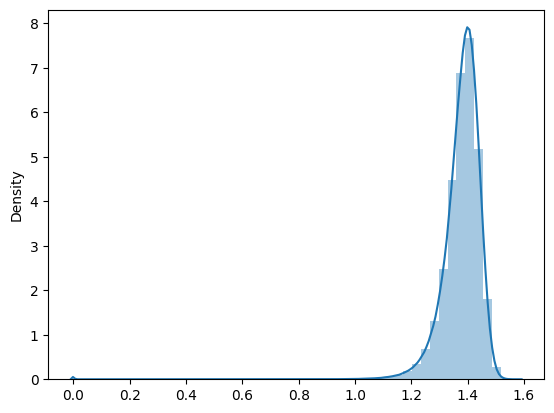

In [ ]:
sns.distplot(train_to_train_distance)


`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_to_test_distance)



<Axes: ylabel='Density'>

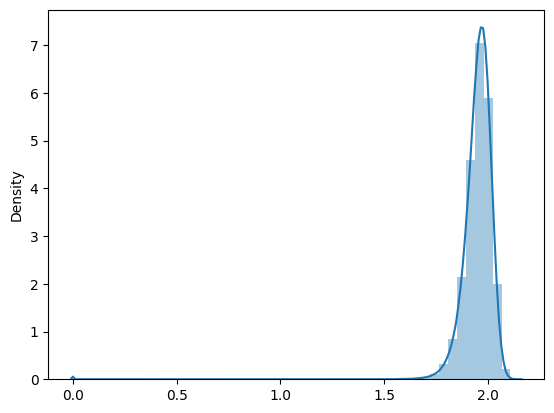

In [ ]:
sns.distplot(train_to_test_distance)

In [ ]:
len(train_to_test_distance), len(train_to_train_distance)

(1981, 2000)

In [ ]:
train_train_distance_pd = pd.Series(list(train_to_train_distance), name='train_to_train_distance')
train_test_distance_pd = pd.Series(list(train_to_test_distance), name='train_to_test_distance')

emb_distance_df = pd.concat([train_train_distance_pd, train_test_distance_pd], axis=0, ignore_index=True)#right_index = True, left_index = True)
emb_distance_df = emb_distance_df.to_frame(name='embedding_distance')
# .reset_index()
emb_distance_df['distance_type'] = ''
emb_distance_df.loc[:2000, 'distance_type'] = 'train_to_train_distance'
emb_distance_df.loc[2000:, 'distance_type'] = 'train_to_test_distance'
emb_distance_df
# emb_distance_df.index[:2000]

  and should_run_async(code)



,embedding_distance,distance_type
0,"[0.0, 1.418379871012059, 1.4245696606787706, 1...",train_to_train_distance
1,"[1.418379871012059, 0.0, 1.330316660570197, 1....",train_to_train_distance
2,"[1.4245696606787706, 1.330316660570197, 0.0, 1...",train_to_train_distance
3,"[1.4981497623519908, 1.4107802539655032, 1.410...",train_to_train_distance
4,"[1.3435513658956895, 1.4422709528501234, 1.385...",train_to_train_distance
...,...,...
3976,"[1.9633365340394981, 2.0006552027888427, 1.970...",train_to_test_distance
3977,"[1.8932136277730935, 1.9213133211052071, 1.944...",train_to_test_distance
3978,"[2.0543070893436077, 1.9326745339485027, 1.996...",train_to_test_distance
3979,"[1.9918040614726618, 1.9982386652179658, 2.013...",train_to_test_distance


See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])



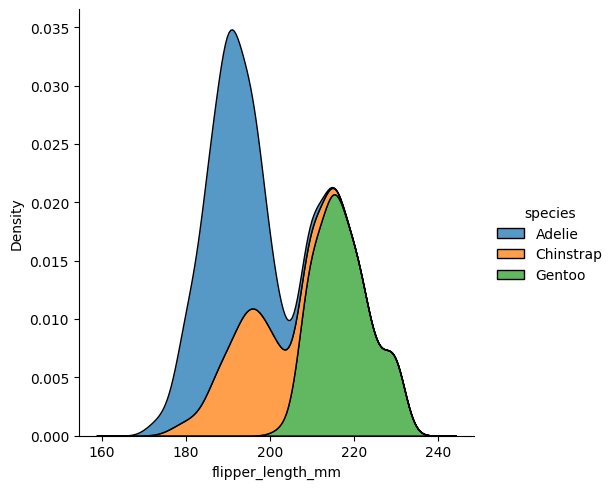

In [ ]:
penguins = sns.load_dataset("penguins")
sns.displot(penguins, x="flipper_length_mm", kind="kde", hue='species', multiple="stack")
# penguins

In [ ]:
sns.displot(emb_distance_df)#, x='embedding_distance', hue="distance_type", kind="kde")#, multiple="stack")

ValueError: ignored